In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [2]:
spark = SparkSession.builder \
    .appName("RandomForestClassification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [3]:
data = spark.read.csv("dataset.csv", header=True, inferSchema=True)


In [4]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



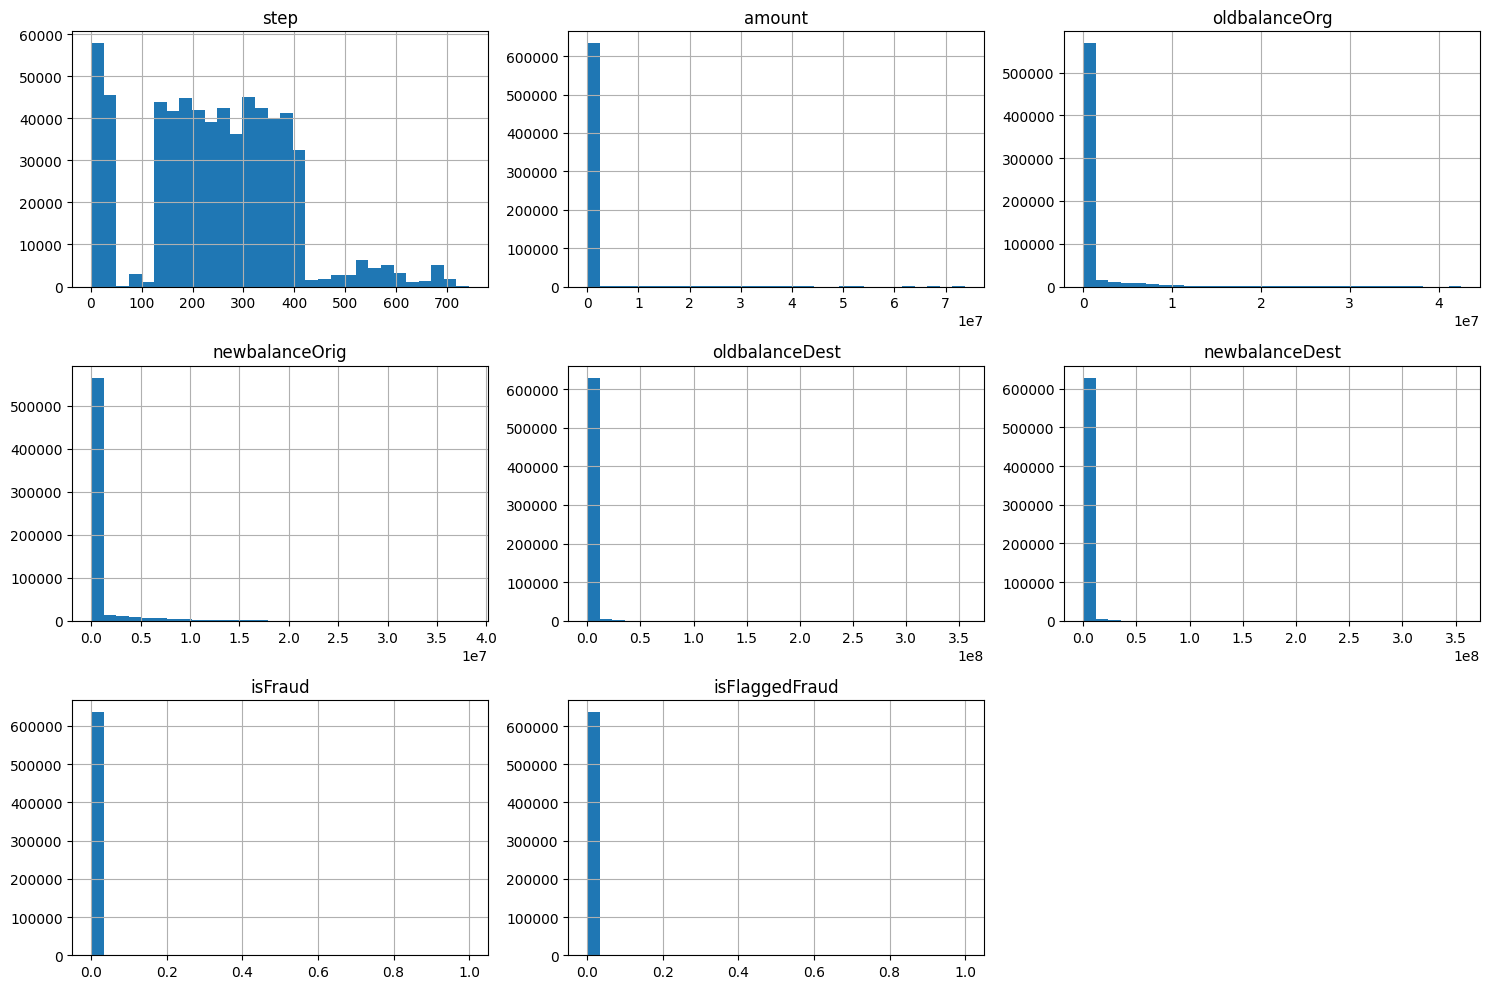

In [5]:
data_sample = data.sample(fraction=0.1, seed=1234)
data_pandas_sample = data_sample.toPandas()

data_pandas_sample.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [6]:
indexer = StringIndexer(inputCol="type", outputCol="type_indexed")
data = indexer.fit(data).transform(data)
data.select("type", "type_indexed").show(5)
data = data.drop('type', 'nameOrig', 'nameDest')
target_column = "isFraud"  
features_columns = data.columns 
features_columns.remove(target_column)
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
data = assembler.transform(data)

+--------+------------+
|    type|type_indexed|
+--------+------------+
| PAYMENT|         1.0|
| PAYMENT|         1.0|
|TRANSFER|         3.0|
|CASH_OUT|         0.0|
| PAYMENT|         1.0|
+--------+------------+
only showing top 5 rows



In [7]:
data.show(10)

+----+--------+-------------+--------------+--------------+--------------+-------+--------------+------------+--------------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_indexed|            features|
+----+--------+-------------+--------------+--------------+--------------+-------+--------------+------------+--------------------+
|   1| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|         1.0|[1.0,9839.64,1701...|
|   1| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|         1.0|[1.0,1864.28,2124...|
|   1|   181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|         3.0|(8,[0,1,2,7],[1.0...|
|   1|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|             0|         0.0|(8,[0,1,2,4],[1.0...|
|   1|11668.14|      41554.0|      29885.86|           0.0|           0.0|  

In [8]:
data.select("features", "isFraud").show()

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[1.0,9839.64,1701...|      0|
|[1.0,1864.28,2124...|      0|
|(8,[0,1,2,7],[1.0...|      1|
|(8,[0,1,2,4],[1.0...|      1|
|[1.0,11668.14,415...|      0|
|[1.0,7817.71,5386...|      0|
|[1.0,7107.77,1831...|      0|
|[1.0,7861.64,1760...|      0|
|(8,[0,1,2,7],[1.0...|      0|
|[1.0,5337.77,4172...|      0|
|[1.0,9644.94,4465...|      0|
|[1.0,3099.97,2077...|      0|
|[1.0,2560.74,5070...|      0|
|(8,[0,1,2,7],[1.0...|      0|
|[1.0,4098.78,5032...|      0|
|[1.0,229133.94,15...|      0|
|(8,[0,1,2,7],[1.0...|      0|
|[1.0,1157.86,2115...|      0|
|[1.0,671.64,15123...|      0|
|[1.0,215310.3,705...|      0|
+--------------------+-------+
only showing top 20 rows



In [9]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)


In [10]:
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="isFraud",
    numTrees=100,           
    maxDepth=10,            
    maxBins=64,             
    minInstancesPerNode=5,  
    subsamplingRate=0.8,    
    featureSubsetStrategy="sqrt"
)

In [11]:
model = rf.fit(train_data)


In [12]:
predictions = model.transform(test_data)


In [13]:
evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9995999588169784


In [14]:
evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print(f"Precision: {precision}")

Precision: 0.9995942403951141


In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1-Score: {f1_score}")

F1-Score: 0.9995671816347479


In [16]:
spark.stop()


# KESIMPULAN
Setelah dilakukan preprocessing data (drop kolom yang tidak relevan dan mengubah kolom kategorial menjadi numerik) dan memilah data untuk dimasukkan sebagai features dan label, didapat hasil akurasi dari model ini sebesar 0.9996023166235581. Pada model ini saya menggunakan RandomForest untuk melakukan classification pada dataset yang sudah ada. Model ini dibuat untuk memprediksi apakah ada kemungkinan dilakukannya penipuan pada transaksi yang dilakukan.

Hasil akurasi yang didapat model ini sangat tinggi, kemungkinan dikarenakan data yang terdapat pada dataset sangat bagus.